<a href="https://colab.research.google.com/github/duongvotran/Water-Hackathon-2021/blob/main/SSV_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing dependencies and dataset

In [91]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.image as mpimg 

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [92]:
file = 'Water_data.xlsx'
sheet = 'SSV-E' # change excel sheet
data = pd.read_excel(file, sheet)

timestamp = data.columns[0]
quality_aspect = data.columns[1] # change examining quality aspect of wastewater
quality = data.filter(items = [timestamp, quality_aspect])
quality.head()

,Date,SSV-E (Volatile Suspended Solid mg/L)
0,1990-01-01,54.4
1,1990-01-02,76.5
2,1990-01-03,65.5
3,1990-01-04,67.8
4,1990-01-07,74.2


#Indexing the time series data

In [93]:
quality = quality.set_index(timestamp)
quality.index

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-07', '1990-01-08', '1990-01-09', '1990-01-10',
               '1990-01-11', '1990-01-12',
               ...
               '1991-08-20', '1991-08-21', '1991-08-22', '1991-08-23',
               '1991-08-25', '1991-08-26', '1991-08-27', '1991-08-28',
               '1991-08-29', '1991-08-30'],
              dtype='datetime64[ns]', name='Date', length=502, freq=None)

In [94]:
train_start = '1990'
resample = '3D' # change the resample rule
y = quality[quality_aspect].resample(resample).mean()
y

Date
1990-01-01    65.466667
1990-01-04    67.800000
1990-01-07    72.433333
1990-01-10    67.133333
1990-01-13    71.450000
                ...    
1991-08-18    68.966667
1991-08-21    75.466667
1991-08-24    64.100000
1991-08-27    66.033333
1991-08-30    69.700000
Freq: 3D, Name: SSV-E (Volatile Suspended Solid mg/L), Length: 203, dtype: float64

# Visualizing

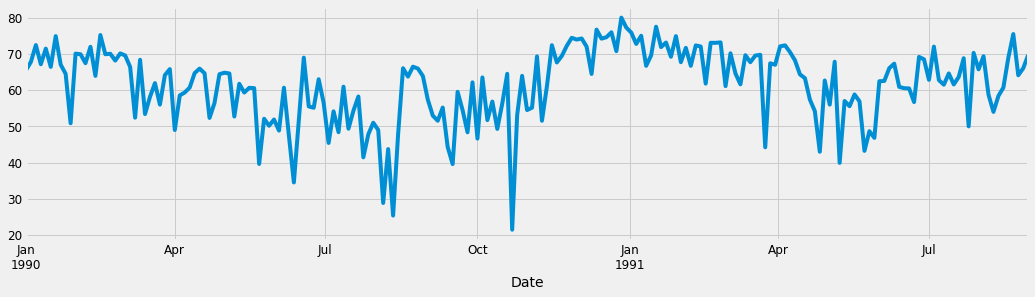

In [95]:
y.plot(figsize=(16, 4))
plt.show()

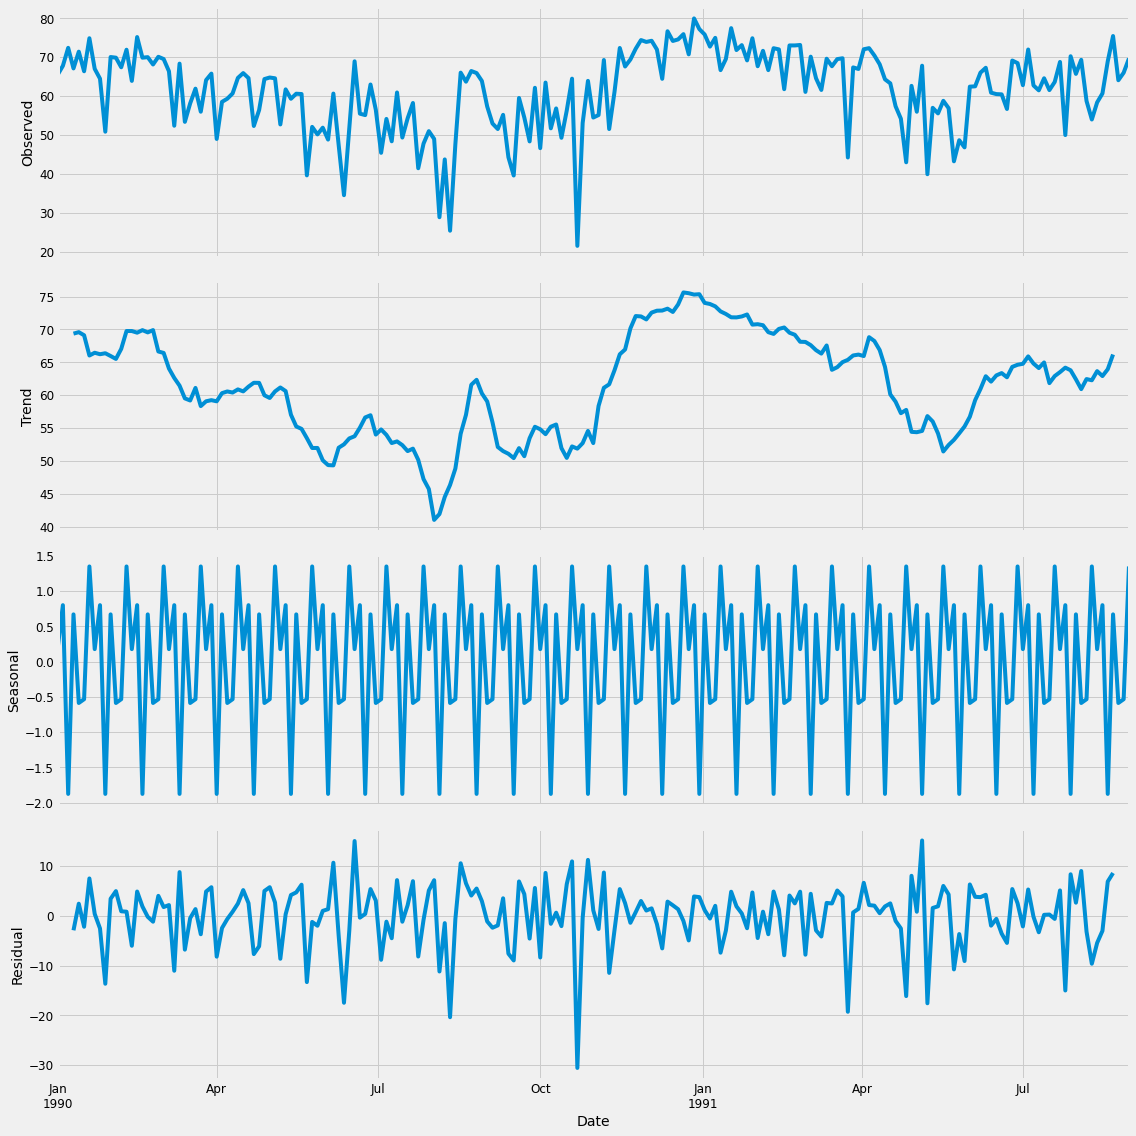

In [96]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 16

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()
fig.savefig("SSV-time-series-components.png")


# Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [97]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
period = 13
seasonal_pdq = [(x[0], x[1], x[2], period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 13)
SARIMAX: (0, 0, 1) x (0, 1, 0, 13)
SARIMAX: (0, 1, 0) x (0, 1, 1, 13)
SARIMAX: (0, 1, 0) x (1, 0, 0, 13)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [98]:
optimal_result = 10**6
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}{} - AIC:{}'.format(param, param_seasonal, period, results.aic))
            
            if results.aic < optimal_result:
              optimal_result = results.aic
              optimal_order = param
              optimal_seasonal_order = param_seasonal
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 13)13 - AIC:2245.0661009594114
ARIMA(0, 0, 0)x(0, 0, 1, 13)13 - AIC:1909.8269960933376
ARIMA(0, 0, 0)x(0, 1, 0, 13)13 - AIC:1480.505413133419
ARIMA(0, 0, 0)x(0, 1, 1, 13)13 - AIC:1361.432951182112
ARIMA(0, 0, 0)x(1, 0, 0, 13)13 - AIC:1487.0269725614658
ARIMA(0, 0, 0)x(1, 0, 1, 13)13 - AIC:1455.8566784230661
ARIMA(0, 0, 0)x(1, 1, 0, 13)13 - AIC:1375.3974066043943
ARIMA(0, 0, 0)x(1, 1, 1, 13)13 - AIC:1351.7272318453124
ARIMA(0, 0, 1)x(0, 0, 0, 13)13 - AIC:2007.2725114106656
ARIMA(0, 0, 1)x(0, 0, 1, 13)13 - AIC:1743.4720498136649
ARIMA(0, 0, 1)x(0, 1, 0, 13)13 - AIC:1454.762389776464
ARIMA(0, 0, 1)x(0, 1, 1, 13)13 - AIC:1320.3451496479504
ARIMA(0, 0, 1)x(1, 0, 0, 13)13 - AIC:1467.445843532307
ARIMA(0, 0, 1)x(1, 0, 1, 13)13 - AIC:1414.7729223023753
ARIMA(0, 0, 1)x(1, 1, 0, 13)13 - AIC:1351.0789026514337
ARIMA(0, 0, 1)x(1, 1, 1, 13)13 - AIC:1318.1359717648456
ARIMA(0, 1, 0)x(0, 0, 0, 13)13 - AIC:1491.538527010005
ARIMA(0, 1, 0)x(0, 0, 1, 13)13 - AIC:1400.91658543247

In [99]:
print('ARIMA{}x{}{} - AIC:{}'.format(optimal_order, optimal_seasonal_order, period, optimal_result))

ARIMA(0, 1, 1)x(0, 1, 1, 13)13 - AIC:1264.4247411044266


# Fitting the ARIMA model

In [100]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order = optimal_order,
                                seasonal_order = optimal_seasonal_order,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7308      0.055    -13.336      0.000      -0.838      -0.623
ma.S.L13      -1.1340      0.124     -9.125      0.000      -1.378      -0.890
sigma2        58.9266     11.544      5.104      0.000      36.300      81.553


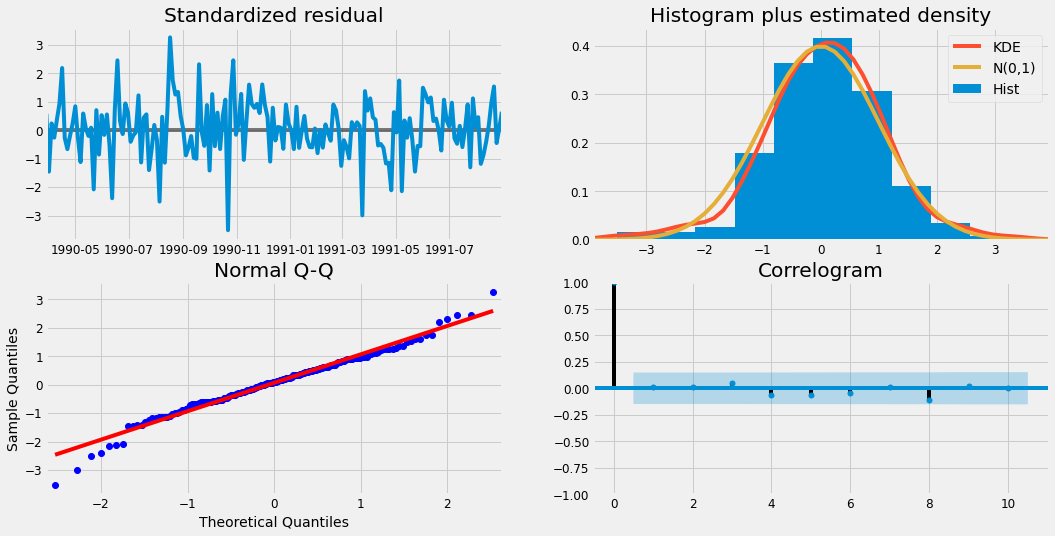

In [101]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts

As we can see in the graph below, there is the test data. The output of our model is placed on top of the real data so that we can have a sense of how difference our output and the real data are.

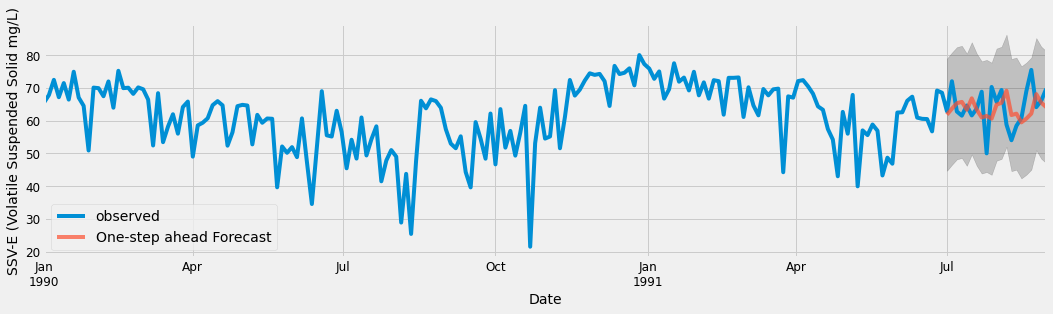

In [102]:
test_start = '1991-07-01' # change the start of test data
pred = results.get_prediction(start=pd.to_datetime(test_start), dynamic=False)
pred_ci = pred.conf_int()

fig=plt.figure()
ax = y[train_start:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(16, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel(timestamp)
ax.set_ylabel(quality_aspect)
plt.legend()

plt.show()
fig.savefig("SSV-validating-forecast.png")

In [103]:
y_forecasted = pred.predicted_mean
y_truth = y[test_start:]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 43.04


In [104]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6.56


#Producing and visualizing forecasts

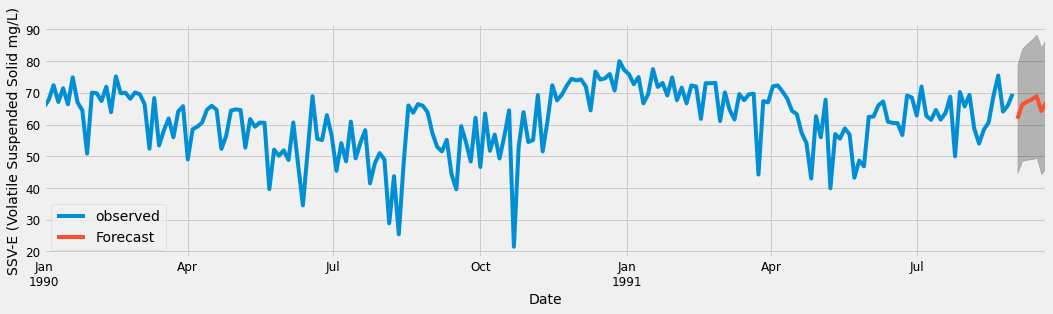

In [105]:
pred_uc = results.get_forecast(steps=7) # change the amount of predicted data
pred_ci = pred_uc.conf_int()

fig = plt.figure()
ax = y.plot(label='observed', figsize=(16, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel(timestamp)
ax.set_ylabel(quality_aspect)

plt.legend()
plt.show()
fig.savefig("SSV-future-forecasting.png")

In [106]:
pred_val = pd.DataFrame(pred_uc.predicted_mean, columns=[quality_aspect])
pred_val

,SSV-E (Volatile Suspended Solid mg/L)
1991-09-02,61.833250
1991-09-05,66.295000
1991-09-08,67.211415
1991-09-11,67.939939
1991-09-14,68.940962
1991-09-17,64.281345
1991-09-20,67.023268


In [107]:
predict_result = [pred_val,pred_ci]
predict_result = pd.concat(predict_result, axis=1)
predict_result.to_excel("SSV-E prediction.xlsx")
predict_result

,SSV-E (Volatile Suspended Solid mg/L),lower SSV-E (Volatile Suspended Solid mg/L),upper SSV-E (Volatile Suspended Solid mg/L)
1991-09-02,61.833250,44.726841,78.939659
1991-09-05,66.295000,48.579523,84.010478
1991-09-08,67.211415,48.907125,85.515706
1991-09-11,67.939939,49.065195,86.814683
1991-09-14,68.940962,49.512506,88.369417
1991-09-17,64.281345,44.314528,84.248162
1991-09-20,67.023268,46.535708,87.510828
